In [1]:
import numpy as np
import qutip as qt
import scipy as sp
from scipy import linalg
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from matplotlib import rc
from cycler import cycler
from cmt import *
import time

rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)

In [2]:
e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps, hbar divided by eV
c = 3e8 * 1e-10 # cm/ps
k = 8.617e-5 # [eV K^-1] Boltzmann's constant

wavelength = 243e-7 #cm
energy_splitting =  h*c/wavelength


In [35]:
class laser:
    def __init__(self,pulse_kwargs):
        # Initialising time-variables
        self.omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
        
        #self.startTime = pulse_kwargs["start"]
        self.startTime = 0
        #self.endTime =  pulse_kwargs["end"] #ps 
        self.endTime = 20
        self.binwidth = 2*np.pi/self.omega0*1000
        self.N_time = int(self.endTime/self.binwidth)
        self.tlist = np.linspace(0,self.endTime,self.N_time)
        #self.tcentre = int((self.endTime-self.startTime)/2 + self.startTime) #ps
        self.tcentre = 10
        self.tlist_centre = np.full(self.N_time,self.tcentre)
        
        self.detuning = pulse_kwargs["detuning"]
        self.chirp0 = pulse_kwargs["chirp"]
        self.rabi0= pulse_kwargs["rabi0"]
        self.pulse_duration = pulse_kwargs["pulse_duration"]
        
        self.label = pulse_kwargs["label"]
        
        self.wavenumber_value = self.omega0/c
        
        self.unit_wavevector = pulse_kwargs["unit_wavevector"]

        self.chirp = lambda tlist,args: [self.chirp0 * (t-self.tcentre)  if t >= self.startTime and t < self.endTime else 0 for t in tlist]
        self.wavenumber = lambda tlist,args: [self.unit_wavevector*self.wavenumber_value if t >= self.startTime and t < self.endTime else 0 for t in tlist] 
        self.wavevector = lambda tlist,args: [self.unit_wavevector if t >= self.startTime and t < self.endTime else 0 for t in tlist]
        self.rabi = lambda t, args: self.rabi0 * np.exp(-4*np.log(2)*(t-self.tcentre)**2/self.pulse_duration**2)
        
class Ps_system:
    def __init__(self):
        self.omega0 = energy_splitting / hbar / hbar_eV# radians THz, energy difference between 1S and 2P in positronium
        self.T = 300 #K temperature of cloud
        self.m = 2*511e3 # eV/c^2
        self.std_deviation = np.sqrt(k*self.T/(self.m/c**2)) #standard deviation of gaussian
        self.amplitude = np.sqrt((self.m/c**2)/(2*np.pi*k*self.T))
        self.N_atoms = int(1e5)
        
        self.N_bins = 250
        self.dv = 1.5e-7 # cm/ps, calculated such that 1 step is the equivalent of 1 unit of photon momentum for Ps
        self.max_vel = self.N_bins*self.dv/2
        
        self.velocity_bins = np.linspace(-self.max_vel,self.max_vel,self.N_bins) #cm/ps
        self.initial_pop = np.zeros(self.N_bins)
        self.dv_bins = np.arange(-self.N_bins//2,self.N_bins//2)
        
    
        self.dp = 173 # eV ps/cm, 1 unit of momentum transfer with wavelength 247e-9nm onto Ps
        self.max_momentum = self.dp*self.N_bins//2 # eV ps/cm
        self.momentum_bins = np.linspace(-self.max_momentum,self.max_momentum,self.N_bins) #eV ps/cm 
        self.bins_bins = np.arange(-self.N_bins//2,self.N_bins//2) # array of bins
        
        self.max_detuning = self.max_vel/c*self.omega0 /(2*np.pi) * 1e3 # GHz
        self.detuning_bins = np.linspace(-self.max_detuning,self.max_detuning,self.N_bins)
        
        
        self.kets = [qt.basis(self.N_bins,n) for n in range(self.N_bins)]

        self.laserDict = dict()
        self.H = []
        self.saved_states =[]
        
    def init_distribution_singular(self):
        self.initial_pop[self.N_bins//2] = self.N_atoms//2
        self.initial_pop[self.N_bins//2+1] = self.N_atoms//2
    def init_distribution_constant(self):
        self.initial_pop = np.full(self.N_bins,self.N_atoms/self.N_bins)
    
    # Assume Maxwell-Boltzmann distribution
    def init_MBdistribution(self):
        for i in range(self.N_bins-1):
            self.initial_pop[i] = int(sp.integrate.quad(lambda v: self.amplitude*np.exp(-v**2/(2*self.std_deviation**2))*1e5,self.velocity_bins[i],self.velocity_bins[i+1])[0])
    
    # get initial Maxwell-Boltzmann distribution
    def get_initial_pop_plot(self):
        fig,ax = plt.subplots()
        #ax.fill_between(self.velocity_bins,0,self.initial_pop)
        ax.plot(self.velocity_bins,self.initial_pop,'.')
        ax.set_xlabel("velocities [cm/ps]")
        ax.set_ylabel("Number of Ps")
        
        return fig,ax
    

    def get_states(self, states="default"):
        if states == "default":
            N_g = np.asarray([np.abs(self.states[2*i,2*i]) for i in range(self.N_bins)])
            N_e = np.asarray([np.abs(self.states[2*i+1,2*i+1]) for i in range(self.N_bins)])
            N = np.asarray([np.abs(self.states[2*i,2*i])+np.abs(self.states[2*i+1,2*i+1]) for i in range(self.N_bins)]) # total
        else:
            N_g = np.asarray([np.abs(states[2*i,2*i]) for i in range(self.N_bins)])
            N_e = np.asarray([np.abs(states[2*i+1,2*i+1]) for i in range(self.N_bins)])
            N = np.asarray([np.abs(states[2*i,2*i])+np.abs(states[2*i+1,2*i+1]) for i in range(self.N_bins)]) # total
        return N_g,N_e,N
    


    # instantiate a new object with name given by label
    def init_pulse(self,pulse_kwargs):
        laserLabel = pulse_kwargs["label"]
        laserObj = laser(pulse_kwargs)
        self.laserDict[laserLabel] = laserObj
    
    
    def init_pulse_cycle(self):
        self.laserDict = sorted(self.laserDict.items(),key=lambda x:x[1].startTime)

        self.startTime = self.laserDict[0][1].startTime
        self.endTime =  self.laserDict[-1][1].endTime
        
        self.binwidth = 2*np.pi/self.omega0*1000
        self.N_time = int(self.endTime/self.binwidth)
        self.tlist = np.linspace(0,self.endTime,self.N_time)
        self.wavenumber_value = self.laserDict[0][1].wavenumber_value

        self.rabi = np.sum([laser[1].rabi(self.tlist,None) for laser in self.laserDict],axis=0)
        self.chirp = np.sum([laser[1].chirp(self.tlist,None) for laser in self.laserDict],axis=0)
        self.wavenumber = np.sum([laser[1].wavenumber(self.tlist,None) for laser in self.laserDict],axis=0)
        self.wavevector = np.sum([laser[1].wavevector(self.tlist,None) for laser in self.laserDict],axis=0)   

        # func which is 1 when wavevector is 1 and 0 everywhere else
        # -"- when wavevector is -1 and 0 everywhere else
        self.func1 = np.asarray([1 if k == 1 else 0 for k in self.wavevector])
        self.func2 = np.asarray([1 if k == -1 else 0 for k in self.wavevector])
        
    # Initialise states in ground
    def init_states_ground(self):
        vel_DM = qt.Qobj(np.sqrt(self.initial_pop))*qt.Qobj(np.sqrt(self.initial_pop)).dag() # density matrix    
        self.states = qt.tensor(vel_DM,qt.Qobj([[1,0],[0,0]])) # density matrix, composite of g/e space and vel space


    # Initialise states in excited
    def init_states_excited(self):
        vel_DM = qt.Qobj(np.sqrt(self.initial_pop))*qt.Qobj(np.sqrt(self.initial_pop)).dag() # density matrix    
        self.states = qt.tensor(vel_DM,qt.Qobj([[0,0],[0,1]])) # density matrix, composite of g/e space and vel space
    
    def get_entropy(self, states="current"):
        if states == "current":
            print("pikk")
            states = self.states
        else:
            print("pikk2")
            states = states

        N_g,N_e,N = self.get_states(states.unit())
        selector = N_g > 0
        entropy = np.sum(-np.asarray(N_g[selector])*np.log(np.asarray(N_g[selector])))

        self.entropy = entropy
        
    def return_plot_all_states(self):
        N_ground = self.get_ground()
        N_excited = self.get_excited()

        fig = plt.figure()
        plt.bar(self.velocity_bins,N_ground,width=self.dv,color="blue",label="N_g")
        plt.bar(self.velocity_bins,N_excited,width=self.dv,color="green",bottom=N_ground,label="N_e")
        plt.xlabel("velocities [cm/ps]")
        plt.ylabel("Number of atoms")
        return fig        

    # Initialise desymmetrized states
    def init_states_desymmetrized(self):
        ground = np.zeros(self.N_bins)
        excited = np.zeros(self.N_bins)
        for i in range(self.N_bins):
            if i < self.N_bins//2:
                ground[i] = np.sqrt(self.initial_pop[i])
            else:
                excited[i] = np.sqrt(self.initial_pop[i])

        ground_DM = qt.Qobj(ground)*qt.Qobj(ground).dag() # density matrix    
        excited_DM = qt.Qobj(excited)*qt.Qobj(excited).dag() # density matrix   
        
        self.states = qt.tensor(ground_DM,qt.Qobj([[1,0],[0,0]])) +qt.tensor(excited_DM,qt.Qobj([[0,0],[0,1]])) 
        # Initialise desymmetrized states
    
    def init_states_desymmetrized2(self):
        ground = np.zeros(self.N_bins)
        excited = np.zeros(self.N_bins)
        for i in range(self.N_bins):
            if i < self.N_bins//2:
                if i % 2 == 0:
                    ground[i] = np.sqrt(self.initial_pop[i])
            else:
                if i % 2 != 0:
                    excited[i] = np.sqrt(self.initial_pop[i])

        ground_DM = qt.Qobj(ground)*qt.Qobj(ground).dag() # density matrix    
        excited_DM = qt.Qobj(excited)*qt.Qobj(excited).dag() # density matrix   
        
        self.states = qt.tensor(ground_DM,qt.Qobj([[1,0],[0,0]])) +qt.tensor(excited_DM,qt.Qobj([[0,0],[0,1]])) 

    # assume Hamiltonian only affects the even n ground states and odd n excited states
    def init_states_ground_fast(self):
        pops = np.zeros(self.N_bins)
        for i in range(0,self.N_bins,2):
            if i % 2 == 0:
                pops[i] = np.sqrt(self.initial_MB)[i]
            else: 
                pops[i] = 0
        
        pops = qt.Qobj(pops)
        self.states = pops*pops.dag() # density matrix   
        

    def  set_Hamiltonian_noCMT(self,laserLabel):
        laser = self.laserDict[laserLabel]

        tensor1 = qt.tensor(qt.qeye(self.N_bins),qt.Qobj([[0,0],[0,1]]))
        tensorn = qt.tensor(qt.num(self.N_bins,offset=1),qt.Qobj([[0,0],[0,1]]))
        tensord = qt.tensor(qt.qeye(self.N_bins),qt.sigmax())
        vel_squared = qt.Qobj(self.velocity_bins)*qt.Qobj(self.velocity_bins).dag()
        

        H0 = hbar*(laser.detuning+laser.direction*self.velocity_bins[0]/c*(laser.omega0+laser.detuning))*tensor1
        Hv0 = hbar * self.dv * (laser.omega0 + laser.detuning) * laser.direction/c * tensorn
        H_v_chirp = hbar*laser.chirp*laser.direction*self.dv/c*tensorn
        H_chirp = hbar * laser.chirp*(1+laser.direction*self.velocity_bins[0]/c)*tensor1
        H_transition = 0.5*hbar*tensord

        H = [H0,Hv0,[H_chirp+H_v_chirp,laser.tlist-laser.tlist_centre],[H_transition,laser.rabi]]
        
        opts = qt.Options(store_states=True)
        result = qt.mesolve(H, self.states,laser.tlist, options = opts)
        self.states = result.states[-1]
            
    # Momentum Transfer included
    # i.e velocity bins are no longer independent from each other
    def set_Hamiltonian_MT(self,laserLabel):
        laser = self.laserDict[0][1]

        omega_recoil = 0.5*hbar*hbar_eV*laser.wavenumber_value**2/(self.m/c**2) # 1/ps   
        print(omega_recoil)
        tensor_vel = qt.tensor(qt.Qobj(np.diag(self.velocity_bins)),qt.qeye(2))        
        tensor_num = qt.tensor(qt.num(self.N_bins,offset=1),qt.qeye(2)) # enumerated tensor
        tensor_g = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n].dag() for n in range(self.N_bins)]),axis=0)),qt.Qobj([[1,0],[0,0]])) # ground 
        tensor_e = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n].dag() for n in range(self.N_bins)]),axis=0)),qt.Qobj([[0,0],[0,1]])) # excited
        tensor_eg = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n+1].dag() for n in range(self.N_bins-1)]),axis=0)),qt.Qobj([[0,0],[1,0]])) # excited to ground
        tensor_ge = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n+1]*self.kets[n].dag() for n in range(self.N_bins-1)]),axis=0)),qt.Qobj([[0,1],[0,0]])) # ground to excited
        
        
        H = []
        H.append(hbar*(tensor_num**2*omega_recoil*(tensor_g+tensor_e) - self.omega0*tensor_vel/c*tensor_e)) # time-independent
        H.append([hbar*(1+tensor_vel/c)*laser.chirp0,laser.tlist-laser.tlist_centre]) # time-dependent terms
        H.append([hbar*(-0.5*tensor_eg-0.5*tensor_ge),laser.rabi]) # time-dependent coupling terms                

        opts = qt.Options(store_states=True)
        result = qt.mesolve(H, self.states,laser.tlist, options = opts)
        self.states = result.states[-1]

    def set_Hamiltonian_MT2(self):   
        self.init_pulse_cycle()
        omega_recoil = 0.5*hbar*hbar_eV*self.wavenumber_value**2/(self.m/c**2) # 1/ps   
        
        tensor_vel = qt.tensor(qt.Qobj(np.diag(self.velocity_bins)),qt.qeye(2))     
        tensor_num = qt.tensor(qt.num(self.N_bins,offset=-self.N_bins//2+1),qt.qeye(2)) # enumerated tensor

        tensor_g = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n].dag() for n in range(self.N_bins)]),axis=0)),qt.Qobj([[1,0],[0,0]])) # ground 
        tensor_e = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n].dag() for n in range(self.N_bins)]),axis=0)),qt.Qobj([[0,0],[0,1]])) # excited
        
        tensor_eg = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n+1].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,0],[1,0]])) # excited to ground
        tensor_ge = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n+1]*self.kets[n].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,1],[0,0]])) # ground to excited
        
        tensor_eg2 = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n+1]*self.kets[n].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,0],[1,0]])) # excited to ground
        tensor_ge2 = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n+1].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,1],[0,0]])) # ground to excited
        
        H = []
        H.append(hbar*(tensor_num**2*omega_recoil*(tensor_g+tensor_e))) # time-independent
        H.append([hbar*tensor_e,self.chirp]) # chirp terms
        H.append([-hbar*self.omega0*tensor_vel/c*tensor_e,self.wavevector]) # velocity term
        H.append([hbar*tensor_vel/c*tensor_e,self.chirp*self.wavevector]) # velocity term
        #H.append([-hbar*(0.5*tensor_ge +0.5*tensor_eg),self.rabi]) # time-dependent coupling terms               

        # try defining H to be actually zero outside of valid window with list comprehension
        H.append([-hbar*(0.5*tensor_ge +0.5*tensor_eg),self.rabi*self.func1]) # time-dependent coupling terms               
        H.append([-hbar*(0.5*tensor_ge2 +0.5*tensor_eg2),self.rabi*self.func2]) # time-dependent coupling terms               
        print(np.asarray(H[0]).shape,np.asarray(H[1]).shape,np.asarray(H[2]).shape)
        opts = qt.Options(store_states=True)
        result = qt.mesolve(H, self.states,self.tlist, options = opts)
        self.states = result.states[-1]


    def set_Hamiltonian_MT3(self):
        self.init_pulse_cycle()
        
        tensor_vel = qt.tensor(qt.Qobj(np.diag(self.velocity_bins)),qt.qeye(2))     
        tensor_num = qt.tensor(qt.num(self.N_bins,offset=-self.N_bins//2+1),qt.qeye(2)) # enumerated tensor

        tensor_g = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n].dag() for n in range(self.N_bins)]),axis=0)),qt.Qobj([[1,0],[0,0]])) # ground 
        tensor_e = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n].dag() for n in range(self.N_bins)]),axis=0)),qt.Qobj([[0,0],[0,1]])) # excited
        
        tensor_eg = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n-1].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,0],[1,0]])) # excited to ground
        tensor_ge = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n-1]*self.kets[n].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,1],[0,0]])) # ground to excited
        
        tensor_eg2 = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n]*self.kets[n+1].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,0],[1,0]])) # excited to ground
        tensor_ge2 = qt.tensor(qt.Qobj(np.sum(np.asarray([self.kets[n+1]*self.kets[n].dag() for n in range(1,self.N_bins-1)]),axis=0)),qt.Qobj([[0,1],[0,0]])) # ground to excited

        states = self.states
        for laser in self.laserDict:
            chirp = np.asarray(laser[1].chirp(laser[1].tlist,None))
            wavevector = laser[1].unit_wavevector
            rabi = np.asarray(laser[1].rabi(laser[1].tlist,None))
            
            omega_recoil = 0#0.5*hbar*hbar_eV*laser[1].wavenumber_value**2/(self.m/c**2) # 1/ps
            H = []
            
            
            H.append(hbar*((tensor_num**2*omega_recoil*(tensor_g+tensor_e)) +(self.omega0-(laser[1].omega0+laser[1].detuning)*(1+tensor_vel/c*wavevector))*tensor_e)) # time-independent
            
            H.append([hbar*(1+tensor_vel/c*wavevector)*tensor_e,chirp]) # chirp terms
            if wavevector == 1:
                H.append([-hbar*(0.5*tensor_ge +0.5*tensor_eg),rabi]) # time-dependent coupling terms               
            else:
                H.append([-hbar*(0.5*tensor_ge2 +0.5*tensor_eg2),rabi]) # time-dependent coupling terms               
            
            opts = qt.Options(store_states=True,nsteps=10000)
            result = qt.mesolve(H, states,laser[1].tlist, options = opts,progress_bar=True)
            
            states = result.states[-1]
            self.saved_states.append(states)
        self.states = states


In [36]:
system = Ps_system()    
wavevector = 1
for i in range(1): # change number of pulses
    flip_pulse = {"rabi0" : 2*np.pi*(1000e-3), "detuning": 0,"chirp" : 2*np.pi*(200e-3),"pulse_duration" : 10 ,"unit_wavevector":wavevector,"start":i*20,"end":20*(1+i)}
    #flip_pulse = {"rabi0" : 2*np.pi*(240e-3), "detuning": 2*np.pi*(-153e-3)*wavevector,"chirp" : 0,"pulse_duration" : 10 ,"unit_wavevector":wavevector,"start":i*20,"end":20*(1+i)}
    flip_pulse["label"] = "laser"+str(i)
    system.init_pulse(flip_pulse)
    wavevector = -wavevector
    
print(system.laserDict)

#system.init_distribution_singular()
system.init_MBdistribution()
#system.init_states_desymmetrized()
system.init_states_desymmetrized2()
system.saved_states.append(system.states)
#system.init_pulse_cycle()

#system.set_Hamiltonian_MT(flip_pulse["label"])
#system.set_Hamiltonian_MT2()

system.set_Hamiltonian_MT3()

{'laser0': <__main__.laser object at 0x7fc94115af80>}
12.5%. Run time:   7.84s. Est. time left: 00:00:00:54
20.8%. Run time:  12.55s. Est. time left: 00:00:00:47
33.3%. Run time:  19.61s. Est. time left: 00:00:00:39
41.7%. Run time:  21.64s. Est. time left: 00:00:00:30
50.0%. Run time:  23.90s. Est. time left: 00:00:00:23
62.5%. Run time:  26.73s. Est. time left: 00:00:00:16
70.8%. Run time:  29.22s. Est. time left: 00:00:00:12
83.3%. Run time:  34.46s. Est. time left: 00:00:00:06
91.7%. Run time:  40.71s. Est. time left: 00:00:00:03
Total run time:  42.88s


In [39]:
print(system.get_entropy(system.saved_states[0]))
print(system.get_entropy())
N_g,N_e,N = system.get_states(system.saved_states[0].unit())
selector = N > 0
entropy = np.sum(-np.asarray(N[selector])*np.log(np.asarray(N[selector])))
print(entropy)

pikk2
None
pikk
None


IndexError: list index out of range

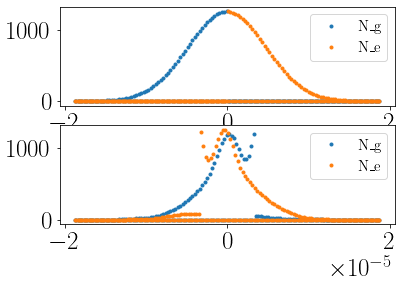

In [76]:
fig, axes = plt.subplots(2)
xaxis = system.velocity_bins
#xaxis_twin = axes[0].twinx()


#plt.xlabel("momen cm/ps")
# fig,axes = plt.subplots(5,figsize=(7,35))
# for i in range(5):
#     axes[i].set_title("pulse"+" " + str(i))
#     axes[i].legend()
    #axes[i].set_xlim(-2e-6,2e-6)

N_g,N_e,N = system.get_states(system.saved_states[0])
axes[0].plot(xaxis,N_g,'.',label="N_g")
axes[0].plot(xaxis,N_e,'.',label="N_e")
#axes[0].plot(xaxis,N,'.',label="total")
axes[0].legend(fontsize=15)
#axes[0].set_xlim(-2e-6,2e-6)

N_g,N_e,N = system.get_states(system.saved_states[22])
axes[1].plot(xaxis,N_g,'.',label="N_g")
axes[1].plot(xaxis,N_e,'.',label="N_e")
#axes[1].plot(xaxis,N,'.',label="total")
axes[1].legend(fontsize=15)
#axes[1].set_xlim(-2e-6,2e-6)

plt.savefig("./figures/cmt/pulse22.jpg",bbox_inches="tight")
# excited = system.get_excited()
# ground = system.get_ground()
# fig,ax = system.get_initial_pop_plot()

# ax.plot(system.velocity_bins,ground,'.',color="black",label="ground")
# ax.plot(system.velocity_bins,excited,'.',color="orange",label="excited")
# #ax.legend()
# ax.set_xlim(-2e-6,2e-6)
# #ax.set_ylim(0,100)
# #plt.savefig("figures/cmt/test_MT_2pulses.jpg")
# plt.show()
# print(excited[system.N_bins//2+1],ground[system.N_bins//2+2],system.initial_pop[system.N_bins//2])

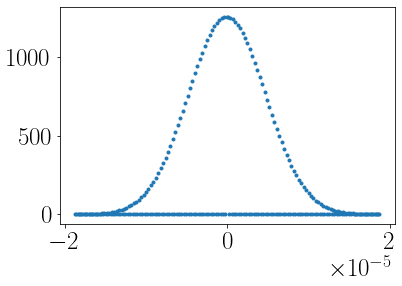

KeyboardInterrupt: 

In [ ]:
N_g,N_e,N = system.get_states(system.saved_states[0])
fig = plt.figure()
ax = fig.add_subplot(111)
line1, = ax.plot(system.velocity_bins,N,'.')
for states in system.saved_states:
    N_g,N_e,N = system.get_states(states)
    line1.set_ydata(N)
    fig.canvas.draw()
    plt.show(fig)
    fig.canvas.flush_events()
    #time.sleep(1)

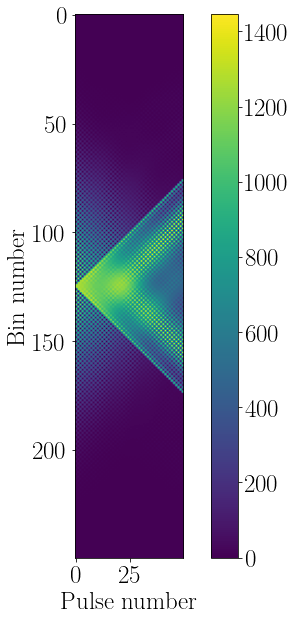

In [ ]:
fig = plt.figure(figsize=(10,10))
X = np.zeros((50,system.N_bins))
for i in range(50):
    N_g,N_e,N = system.get_states(system.saved_states[i])
    X[i] = N
plt.imshow(X.T)
plt.colorbar()
plt.xlabel("Pulse number")
plt.ylabel("Bin number")
#plt.savefig("./figures/cmt/gradient2.jpg",bbox_inches="tight")

Text(0, 0.5, 'number of atoms')

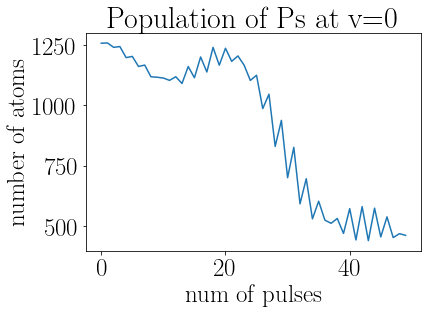

In [ ]:
fig = plt.figure()
#print(np.asarray(system.saved_states).shape)
pops = np.zeros(50)
for i in range(50):
    N_g,N_e,N = system.get_states(system.saved_states[i])
    pops[i] = N[system.N_bins//2]
plt.plot([i for i in range(50)], pops)
plt.title("Population of Ps at v=0")
plt.xlabel("num of pulses")
plt.ylabel("number of atoms")
#plt.savefig("./figures/cmt/pop_at_zero_vel.jpg",bbox_inches="tight")

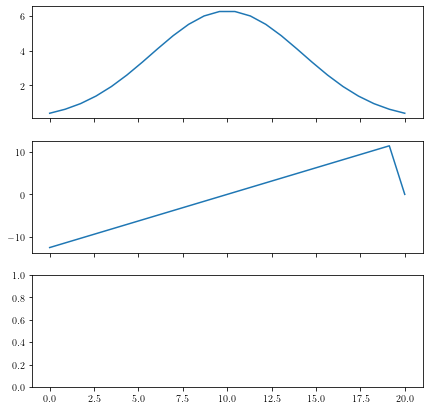

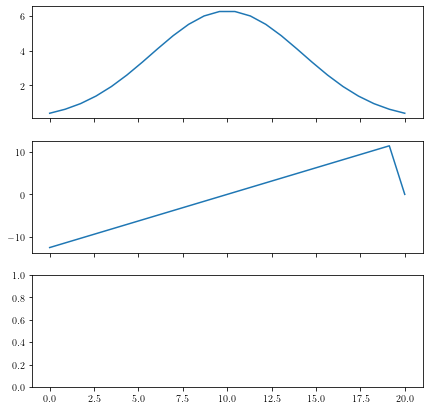

In [ ]:
for laser in system.laserDict:
    laserObj = laser[1]    
    fig,axes = plt.subplots(2,sharex=True,figsize=(7,7))
    axes[0].plot(laserObj.tlist,laserObj.rabi(laserObj.tlist,None))
    #axes[0].set_ylabel(r"$\Omega$ [THz]")
    axes[1].plot(laserObj.tlist,laserObj.chirp(laserObj.tlist,None))
    #axes[1].set_ylabel("r$\alpha$ [THz/ps]")
    #axes[2].plot(laserObj.tlist,laserObj.wavevector)
    #axes[2].set_ylabel("k")
    #axes[2].set_xlabel("time [ps]")
    plt.show()           

KeyError: 0

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.5 0. ]
 [0.  0.5]]
